# 1. Importieren der benötigten Bibliotheken

In [ ]:
import pytorch_train as pt
import torch
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, cuda
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
import torch.optim as optim
from tqdm import tqdm
from pytorch_train import SimpleCNN
import os
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, cuda
import torchvision 
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
import torch.optim as optim
from tqdm import tqdm
from fairlearn.metrics import MetricFrame
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from fairlearn.datasets import fetch_adult
import torchvision.transforms as transforms
from torchcam.methods import GradCAM, SmoothGradCAMpp, LayerCAM, XGradCAM, ScoreCAM, GradCAMpp
from torch.autograd import Variable

# 2. ML-Model Testen

## 2.1 PyTorch Modell Inferenz

### PyTorch Modell Inferenz

Dieser Codeblock führt Inferenz (Vorhersagen) auf einem Testdatensatz mit einem vortrainierten PyTorch Modell durch.

##### Modellpfad und Gerätekonfiguration

```python
model_path = f'{model_path_git}model_git{batch_size}' + '-' + f'{epochs}' + '.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```

Zuerst wird der Pfad zum vortrainierten Modell erstellt, indem der Basispfad, der Name des Modells, die Batch-Größe und die Anzahl der Epochen kombiniert werden. Dann wird das Gerät auf "cuda" gesetzt, wenn eine GPU verfügbar ist, sonst auf "cpu".

##### Modellinitialisierung und Gewichtsladung

```python
model = SimpleCNN()
model.load_state_dict(torch.load(model_path))
```

Ein neues Modell wird erstellt (in diesem Fall ein einfaches CNN). Das Modell wird dann mit den Gewichten geladen, die unter dem angegebenen Pfad gespeichert sind.

##### Inferenz auf dem Testdatensatz

```python
for inputs, _ in test_dataloader:
    inputs = inputs.to(device) 
    output = model(inputs)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    predictions_list = predictions.cpu().numpy().tolist()
    print(predictions_list)
```

Für jede Eingabe im Testdatensatz werden die Eingaben auf das Gerät verschoben (GPU oder CPU). Das Modell macht dann eine Vorhersage auf den Eingaben. Die Ausgabe des Modells wird in Wahrscheinlichkeiten umgewandelt, indem die Softmax-Funktion angewendet wird. Die Klasse mit der höchsten Wahrscheinlichkeit wird als Vorhersage ausgewählt. Schließlich werden die Vorhersagen in eine Liste umgewandelt und ausgegeben.



## Model und zu testendes Modell festlegen

In [ ]:
model = SimpleCNN()
def get_model_path(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".pth"):
            return os.path.join(directory, filename)
    return None

model_path = get_model_path("test/model_to_be_tested")
print(model_path)

## Transformation festlegen

In [ ]:
# Transformation der Daten für das Training und Testen  
transform = transforms.Compose([
    transforms.Resize((178, 218)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


## Testdataset/-dataloader festlegen

In [ ]:
batch_size = 64
with open('test/epochs/batch_size.txt', 'r') as f:
    batch_size = int(f.read())
    
test_dataset = datasets.ImageFolder(root= 'data/train-test-data/test',transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Gerät auswählen worauf das Modell trainiert werden soll

In [ ]:
# Das Gerät wird auf "cuda" gesetzt, wenn eine GPU verfügbar ist, sonst auf "cpu".
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Zu testendes Modell laden

In [ ]:
# Das Modell wird mit den Gewichten geladen, die unter dem angegebenen Pfad gespeichert sind.
model.load_state_dict(torch.load(model_path))


## Modell in Evaluations-Modus versetzen

In [ ]:
model.eval()

## Modell auf Grundlage des Testdataloaders testen

In [ ]:

# Für jede Eingabe im Testdatensatz:
for inputs, _ in test_dataloader:
    # Die Eingaben werden auf das Gerät verschoben (GPU oder CPU).
    inputs = inputs.to(device) 
    # Das Modell macht eine Vorhersage auf den Eingaben.
    output = model(inputs)
    # Die Ausgabe des Modells wird in Wahrscheinlichkeiten umgewandelt, indem die Softmax-Funktion angewendet wird.
    probabilities = torch.nn.functional.softmax(output, dim=1)
    # Die Klasse mit der höchsten Wahrscheinlichkeit wird als Vorhersage ausgewählt.
    predictions = torch.argmax(probabilities, dim=1)
    # Die Vorhersagen werden in eine Liste umgewandelt und ausgegeben.
    predictions_list = predictions.cpu().numpy().tolist()
    print(predictions_list)

## 4.2 PyTorch Modell Inferenz und Genauigkeitsberechnung

Dieser Codeblock führt Inferenz (Vorhersagen) auf einem Testdatensatz mit einem vortrainierten PyTorch Modell durch und berechnet die Genauigkeit der Vorhersagen.

### Modellladen und Testdaten-Loader

```python
model = SimpleCNN()
model.load_state_dict(torch.load(model_path))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
```

Zuerst wird ein neues Modell erstellt (in diesem Fall ein einfaches CNN) und mit den Gewichten geladen, die unter dem angegebenen Pfad gespeichert sind. Dann wird ein DataLoader für den Testdatensatz erstellt, mit einer Batch-Größe von 64 und ohne Shuffle.

### Inferenz und Genauigkeitsberechnung

```python
correct = 0
total = 0

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Genauigkeit des Modells auf Testbilder: {}%'.format(100 * accuracy))
```

Zwei Zähler werden initialisiert: `correct` für die Anzahl der korrekten Vorhersagen und `total` für die Gesamtzahl der Vorhersagen. Für jede Eingabe und das zugehörige Label im Testdatensatz werden die Eingaben und Labels auf das Gerät verschoben (GPU oder CPU). Das Modell macht dann eine Vorhersage auf den Eingaben und die Klasse mit der höchsten Ausgabe wird als Vorhersage ausgewählt. Die `total` und `correct` Zähler werden entsprechend aktualisiert. Schließlich wird die Genauigkeit berechnet als das Verhältnis von `correct` zu `total` und ausgegeben.




## 4.3 PyTorch Modell Inferenz und Metrikenberechnung

Dieser Codeblock führt Inferenz (Vorhersagen) auf einem Testdatensatz mit einem vortrainierten PyTorch Modell durch und berechnet verschiedene Metriken zur Beurteilung der Modellleistung.

### Modell Evaluierung und Inferenz

```python
model.eval() 
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)
```

Zuerst wird das Modell in den Evaluierungsmodus gesetzt. Dann werden zwei Listen initialisiert: `predictions` für die Vorhersagen des Modells und `true_labels` für die tatsächlichen Labels. Für jede Eingabe und das zugehörige Label im Testdatensatz macht das Modell eine Vorhersage und die Klasse mit der höchsten Ausgabe wird als Vorhersage ausgewählt. Die Vorhersagen und tatsächlichen Labels werden den entsprechenden Listen hinzugefügt.

### Konvertierung in numpy-Arrays und Metrikenberechnung

```python
predictions = np.array(predictions)
true_labels = np.array(true_labels)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Genauigkeit: {accuracy}, Präzision: {precision}, Recall: {recall}, F1-Score: {f1}')
```

Die Listen `predictions` und `true_labels` werden in numpy-Arrays umgewandelt. Dann werden verschiedene Metriken berechnet: Genauigkeit, gewichtete Präzision, gewichteter Recall und gewichteter F1-Score. Diese Metriken werden ausgegeben.

### Speichern der Metriken

```python
with open('model/metrics/metrics.txt', 'w') as outfile:
    outfile.write(f'Modellmetriken: Genauigkeit: {accuracy}, Präzision: {precision}, Recall: {recall}, F1-Score: {f1}')
```

Die berechneten Metriken werden in einer Textdatei gespeichert.

---

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
# Setze das Modell in den Evaluierungsmodus

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)


# Konvertiere die Listen in numpy-Arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Berechne die Metriken
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Genauigkeit: {accuracy}, Präzision: {precision}, Recall: {recall}, F1-Score: {f1}')

with open('test/metrics/metrics.txt', 'w') as outfile:
    outfile.write(f'Modellmetriken: Genauigkeit: {accuracy}, Präzision: {precision}, Recall: {recall}, F1-Score: {f1}')


In [ ]:
predictions = []
labels_list = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        
        # Flatten the outputs and convert to numpy array
        predictions.extend(outputs.view(-1).cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
        
# Flatten the arrays
predictions = np.array(predictions).ravel()
labels_list = np.array(labels_list).ravel()
print(predictions)
print(labels_list)

# Ensure both arrays have the same length
min_length = min(len(predictions), len(labels_list))
predictions = predictions[:min_length]
labels_list = labels_list[:min_length]

predictions = np.array(predictions).ravel()
labels_list = np.array(labels_list).ravel()

# Plot true labels against predictions
# plt.scatter(labels_list,predictions)
plt.scatter(labels_list,predictions)
plt.grid(True)
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.xlabel('True Labels',color='blue')
plt.ylabel('Predictions',color='red')
plt.title('True Labels vs Predictions')

plt.savefig("model/plots/plot_scatter.jpg",dpi=100)
plt.show()


plt.plot([labels_list.min(), labels_list.max()], [predictions.min(), predictions.max()], 'k--', lw=4)
plt.grid(True)
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.xlabel('True Labels',color='blue')
plt.ylabel('Predictions',color='red')
plt.title('True Labels vs Predictions')
plt.savefig("model/plots/plot_plt.jpg",dpi=100)
plt.show()

# Create a 2D histogram from the data
heatmap_data, xedges, yedges = np.histogram2d(labels_list, predictions, bins=50)


# Plot the heatmap
plt.imshow(heatmap_data, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Anzahl')
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Heatmap of True Labels vs Predictions')
plt.savefig("model/plots/heatmap.jpg", dpi=100)
plt.show()

## 4.3 ML-Test mit Fairlearn

## 4.3.1 Daten für Fairlearn vorbereiten

## Extraktion der Bilder und Labels für Fairlearn -> Speicherung in einer CSV-Datei

In [ ]:
 
train_men = r"data/train-test-data/train/men"
train_women = r"data/train-test-data/train/women"
def create_gender_labelled_csv(men_folder, women_folder, output_csv):
    # Liste der Dateien in den Ordnern erstellen
    men_files = os.listdir(men_folder)
    women_files = os.listdir(women_folder)

    # DataFrame für Männer und Frauen erstellen
    men_df = pd.DataFrame({
        'filename': men_files,
        'Male': [1]*len(men_files)  # 1 für Männer
    })

    women_df = pd.DataFrame({
        'filename': women_files,
        'Male': [-1]*len(women_files)  # -1 für Frauen
    })

    # Beide DataFrames zusammenfügen
    combined_df = pd.concat([men_df, women_df])

    # DataFrame als CSV speichern
    combined_df.to_csv(output_csv, index=False)

# Funktion aufrufen
create_gender_labelled_csv(train_men, train_women, "gender_labelled.csv")

In [ ]:
X_train = []
y_train = []
y_test = []
y_pred = []
sensitive_features = ["men","women"]

train_men = "data/train-test-data/train/men"
train_women = "data/train-test-data/train/women"
val_men = "data/train-test-data/test/men"
val_women = "data/train-test-data/test/women"
csv = "data/source_csv/list_attr_celeba.csv"
folder = "data/img_align_celeba"
train = "data/train-test-data/train"
test = "data/train-test-data/test"
merged_csv = "gender_labelled.csv"   

# Transformation der Daten für das Training und Testen  
transform = transforms.Compose([
    transforms.Resize((178, 218)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train, transform=transform)
test_dataset = datasets.ImageFolder(test, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)     

# Lesen Sie die CSV-Datei
df = pd.read_csv(merged_csv)

# Extrahieren Sie die Werte der 'male' Spalte
sensitive_features = df['Male'].tolist()
sensitive_features = pd.Series(sensitive_features).replace({-1: 'Frau', 1: 'Mann'}).tolist()


for inputs, labels in train_dataloader:
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    y_test.extend(labels.numpy())
    y_pred.extend(preds.numpy())

    # sensitive_features.extend(extracted_features)

# Berechnung der Fairness-Metriken
metrics = MetricFrame(accuracy_score, y_test, y_pred, sensitive_features=sensitive_features)

# Fairness-Metriken ausgeben
print(metrics.by_group)




In [ ]:

# Erstellen Sie eine Liste der Gruppennamen und ihrer Genauigkeiten
groups = metrics.by_group.index.tolist()
accuracies = metrics.by_group.values.tolist()

# Erstellen Sie ein Balkendiagramm
plt.bar(groups, accuracies)

# Fügen Sie Titel und Beschriftungen hinzu
plt.title('Accuracy by group')
plt.xlabel('Group')
plt.ylabel('Accuracy')

# Zeigen Sie das Diagramm an
plt.show()
plt.savefig("test/metrics/plot_bar.jpg", dpi=100)

In [ ]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

sensitive_features = pd.Series(sensitive_features).replace({-1: 'Frau', 1: 'Mann'}).tolist()
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features
)
ax = metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metriken anzeigen!",
)
# Durchlaufen Sie jeden Subplot und passen Sie die y-Achsen-Ticks an
for row in ax:
    for subplot in row:
        subplot.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Zeigen Sie die Plots an
plt.show()
plt.savefig("test/metrics/metrics.jpg", dpi=100)


In [ ]:

# Customize plots with ylim
metric_frame.by_group.plot(
    kind="bar",
    ylim=[0, 2],
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics with assigned y-axis range",
)

In [ ]:
# Customize plots with colormap
metric_frame.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Show all metrics in Accent colormap",
)


# Saving plots
fig = metric_frame.by_group[["count"]].plot(
    kind="pie",
    subplots=True,
    layout=[1, 1],
    legend=True,
    figsize=[12, 8],
    labels=["Frau","Mann"],
    autopct="%.2f",
    title="Metriken als Kuchen-Diagramm",
)

if "__file__" in locals():
    fig[0][0].figure.savefig("test/metricsFairlearn/metricsFairLearn.jpg", dpi=100)




# 2. Testdataset erstellen

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

model = SimpleCNN()  # Instantiate the model


# model_path = f'model/PyTorch_Trained_Models/model64-91acc-100.pth'
model.load_state_dict(torch.load(model_path, map_location=device))  # Load the state_dict
test_dataset = datasets.ImageFolder("data/train-test-data/test", transform=transform)
# test_dataset = datasets.ImageFolder(r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output\val", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

for inputs, _ in test_dataloader:
    inputs = inputs.to(device) 
    output = model(inputs)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    predictions_list = predictions.cpu().numpy().tolist()
    print(predictions_list)

   

## 2.1 Robustheit des ML-Models Testen auf Testbilder

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model_robustness(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Do not calculate gradients to speed up computation
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'::warning::Accuracy: {accuracy}')
    print(f'::warning::Precision: {precision}')
    print(f'::warning::Recall: {recall}')
    print(f'::warning::F1 Score: {f1}')
    return accuracy, precision, recall, f1


test_model_robustness(model, test_dataloader, device)

## 2.2 Testdaten verrauschen

### `add_noise` Funktion
Die Funktion `add_noise` fügt einem gegebenen Bild Rauschen hinzu.

#### Parameter

- `images`: Die Bilder, zu denen Rauschen hinzugefügt werden soll.
- `noise_factor`: Der Faktor, der bestimmt, wie viel Rauschen hinzugefügt wird. Standardmäßig ist dieser Wert 0.5.

#### Rückgabewert

Die Funktion gibt die verrauschten Bilder zurück.

### `add_noise_and_test` Funktion

Die Funktion `add_noise_and_test` fügt den Testbildern Rauschen hinzu und testet dann das Modell mit diesen verrauschten Bildern.

#### Parameter

- `model`: Das zu testende Modell.
- `test_dataloader`: Ein DataLoader, der die Testdaten bereitstellt.
- `device`: Das Gerät, auf dem das Modell ausgeführt wird (z.B. 'cpu' oder 'cuda').
- `noise_factor`: Der Faktor, der bestimmt, wie viel Rauschen hinzugefügt wird. Standardmäßig ist dieser Wert 0.5.

#### Funktionsweise

Die Funktion fügt den Testbildern Rauschen hinzu und erstellt dann einen neuen DataLoader mit den verrauschten Bildern. Anschließend wird das Modell mit diesen verrauschten Bildern getestet.

### Beispiel

```python
add_noise_and_test(model, test_dataloader, device)
```

In diesem Beispiel wird die Funktion `add_noise_and_test` aufgerufen, um Rauschen zu den Testbildern hinzuzufügen und dann das Modell `model` mit diesen verrauschten Bildern zu testen. Die Testdaten werden vom `test_dataloader` bereitgestellt und das Modell wird auf dem `device` ausgeführt. Der Rauschfaktor beträgt 0.5.

In [ ]:
def add_noise(images, noise_factor=0.5):
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

def add_noise_and_test(model, test_dataloader, device, noise_factor=0.5):
    noisy_images = []
    labels_list = []
    
    for inputs, labels in test_dataloader:
        inputs_noisy = add_noise(inputs, noise_factor)
        noisy_images.append(inputs_noisy)
        labels_list.append(labels)

    # Stack images and labels separately
    noisy_images = torch.cat(noisy_images)
    labels_list = torch.cat(labels_list)

    noisy_dataloader = torch.utils.data.DataLoader(list(zip(noisy_images, labels_list)), batch_size=test_dataloader.batch_size)

    test_model_robustness(model, noisy_dataloader, device)

# Verwendung der Funktion
add_noise_and_test(model, test_dataloader, device)



## 2.3 Model auf verrauschte Bilder testen


### Dokumentation für `test_noise_robustness` Funktion

Die Funktion `test_noise_robustness` testet die Robustheit eines Modells gegenüber Bildrauschen. Sie nimmt ein Modell, einen DataLoader für Testdaten, ein Gerät und optionale Parameter für den Start-, End- und Schrittwert des Rauschfaktors an.

### Parameter

- `model`: Das zu testende Modell.
- `test_dataloader`: Ein DataLoader, der die Testdaten bereitstellt.
- `device`: Das Gerät, auf dem das Modell ausgeführt wird (z.B. 'cpu' oder 'cuda').
- `start_noise`: Der Startwert für den Rauschfaktor. Standardmäßig ist dieser Wert 0.0.
- `end_noise`: Der Endwert für den Rauschfaktor. Standardmäßig ist dieser Wert 1.0.
- `step`: Der Schrittwert, um den der Rauschfaktor bei jedem Durchlauf erhöht wird. Standardmäßig ist dieser Wert 0.1.

### Funktionsweise

Die Funktion fügt den Testbildern schrittweise Rauschen hinzu, beginnend mit dem `start_noise`-Wert und endend mit dem `end_noise`-Wert. Bei jedem Schritt wird das Modell mit den verrauschten Bildern getestet und die Genauigkeit, Precision, Recall und der F1-Score werden berechnet und neben einem Beispielbild angezeigt.

Wenn die Genauigkeit des Modells unter 70% fällt, wird der Test gestoppt.

### Beispiel

```python
test_noise_robustness(model, test_dataloader, device)
```

In diesem Beispiel wird die Funktion `test_noise_robustness` aufgerufen, um die Robustheit des Modells `model` gegenüber Bildrauschen zu testen. Die Testdaten werden vom `test_dataloader` bereitgestellt und das Modell wird auf dem `device` ausgeführt. Der Rauschfaktor startet bei 0.0 und endet bei 1.0, wobei er bei jedem Durchlauf um 0.1 erhöht wird.



Die Funktion `test_noise_robustness` testet die Robustheit eines Modells gegenüber Bildrauschen. Sie nimmt ein Modell, einen DataLoader für Testdaten, ein Gerät und optionale Parameter für den Start-, End- und Schrittwert des Rauschfaktors an.

### Parameter

- `model`: Das zu testende Modell.
- `test_dataloader`: Ein DataLoader, der die Testdaten bereitstellt.
- `device`: Das Gerät, auf dem das Modell ausgeführt wird (z.B. 'cpu' oder 'cuda').
- `start_noise`: Der Startwert für den Rauschfaktor. Standardmäßig ist dieser Wert 0.0.
- `end_noise`: Der Endwert für den Rauschfaktor. Standardmäßig ist dieser Wert 1.0.
- `step`: Der Schrittwert, um den der Rauschfaktor bei jedem Durchlauf erhöht wird. Standardmäßig ist dieser Wert 0.1.

### Funktionsweise

Die Funktion fügt den Testbildern schrittweise Rauschen hinzu, beginnend mit dem `start_noise`-Wert und endend mit dem `end_noise`-Wert. Bei jedem Schritt wird das Modell mit den verrauschten Bildern getestet und die Genauigkeit, Precision, Recall und der F1-Score werden berechnet und neben einem Beispielbild angezeigt.

Wenn die Genauigkeit des Modells unter 70% fällt, wird der Test gestoppt.

### Beispiel

```python
test_noise_robustness(model, test_dataloader, device)
```

In diesem Beispiel wird die Funktion `test_noise_robustness` aufgerufen, um die Robustheit des Modells `model` gegenüber Bildrauschen zu testen. Die Testdaten werden vom `test_dataloader` bereitgestellt und das Modell wird auf dem `device` ausgeführt. Der Rauschfaktor startet bei 0.0 und endet bei 1.0, wobei er bei jedem Durchlauf um 0.1 erhöht wird.

In [ ]:
def test_noise_robustness(model, test_dataloader, device, start_noise=0.0, end_noise=1.0, step=0.1):
    noise_factor = start_noise
    i = 0
    while noise_factor <= end_noise:
        noisy_images = []
        labels_list = []

        for inputs, labels in test_dataloader:
            inputs_noisy = add_noise(inputs, noise_factor)
            noisy_images.append(inputs_noisy)
            labels_list.append(labels)

        noisy_images = torch.cat(noisy_images)
        labels_list = torch.cat(labels_list)

        noisy_dataloader = torch.utils.data.DataLoader(list(zip(noisy_images, labels_list)), batch_size=test_dataloader.batch_size)

        print(f'::warning::Test mit noise factor: {noise_factor}')
        accuracy, precision,recall, f1 = test_model_robustness(model, noisy_dataloader, device)
        

        # Show a sample noisy image
        plt.figure(figsize=(12, 6))
        plt.title(f'Verauschtes Bild mit noise factor: {noise_factor}.', fontsize=10)
        plt.imshow(noisy_images[0].permute(1, 2, 0))
        plt.text(1.2, 0.6, f'Genauigkeit: {accuracy}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.5, f'Precision: {precision}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.4, f'Recall: {recall}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.3, f'F1 Score: {f1}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.savefig(f"test/test-plots-rauschen/{i}.png")
        print(f"test/test-plots-verzerrung/{i}.png")
        plt.show()

        if accuracy < 0.7:
            print(f'::warning::Genauigkeit unter 70% mit noise factor: {noise_factor}. Test wird gestoppt.')
            break
        i += 1
        noise_factor += step

# Verwendung der Funktion
test_noise_robustness(model, test_dataloader, device)

## 2.4 Testdaten mit Verzerrungen erstellen 


In [ ]:
import torchvision.transforms.functional as TF


def add_distortion(image, distortion_factor=0.5):
    # Create the distortion matrix
    startpoints = torch.tensor([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
    endpoints = startpoints + torch.tensor([[0.0, distortion_factor], [0.0, -distortion_factor], [0.0, 0.0], [0.0, 0.0]])

    # Apply the distortion to the image
    distorted_image = TF.perspective(image, startpoints, endpoints)

    return distorted_image
        

In [ ]:
def test_distortion_robustness(model, test_dataloader, device, start_distortion=0.0, end_distortion=1.0, step=0.0001):
    distortion_factor = start_distortion
    i = 0
    while distortion_factor <= end_distortion:
        distorted_images = []
        labels_list = []

        for inputs, labels in test_dataloader:
            inputs_distorted = add_distortion(inputs, distortion_factor)
            distorted_images.append(inputs_distorted)
            labels_list.append(labels)

        distorted_images = torch.cat(distorted_images)
        labels_list = torch.cat(labels_list)

        distorted_dataloader = torch.utils.data.DataLoader(list(zip(distorted_images, labels_list)), batch_size=test_dataloader.batch_size)

        print(f'Test mit distortion factor: {distortion_factor}')
        accuracy, precision, recall, f1 = test_model_robustness(model, distorted_dataloader, device)
        
        # Show a sample distorted image
        plt.figure(figsize=(12, 6))
        plt.title(f'Verzerrtes Bild mit distortion factor: {distortion_factor}.', fontsize=10)
        plt.imshow(distorted_images[0].permute(1, 2, 0))
        plt.text(1.2, 0.6, f'Genauigkeit: {accuracy}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.5, f'Precision: {precision}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.4, f'Recall: {recall}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.3, f'F1 Score: {f1}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.savefig(f"test/test-plots-verzerrung/{i}.png")
        print(f"test/test-plots-verzerrung/{i}.png")
        plt.show()

        if accuracy < 0.7:
            print(f'::warning::Genauigkeit unter 70% mit distortion factor: {distortion_factor}. Test wird gestoppt.')
            break
        i += 1
        distortion_factor += step

test_distortion_robustness(model, test_dataloader, device)

# 2.3 Modell mit 90° Drehung testen

In [ ]:
import os
import random
from PIL import Image

def rotate_and_save_random_images(image_folder, output_folder, num_images, rotation_angle=90):
    # Liste aller Bilder im Ordner erstellen
    all_images = os.listdir(image_folder)

    # Zufällige Bilder auswählen
    random_images = random.sample(all_images, num_images)

    for image_name in random_images:
        # Bild öffnen
        img = Image.open(os.path.join(image_folder, image_name))

        # Bild um 90 Grad drehen
        rotated_img = img.rotate(rotation_angle)

        # Gedrehtes Bild speichern
        rotated_img.save(os.path.join(output_folder, 'rotated_' + image_name))

# # Funktion aufrufen
# rotate_and_save_random_images(r'C:\CICDPipeline\CICD-Pipeline-Gender-Recognition\data\train-test-data\train\women', r'C:\CICDPipeline\CICD-Pipeline-Gender-Recognition\test\test_rotated_images_90', 3,90)
# rotate_and_save_random_images(r'C:\CICDPipeline\CICD-Pipeline-Gender-Recognition\data\train-test-data\train\women', r'C:\CICDPipeline\CICD-Pipeline-Gender-Recognition\test\test_rotated_images_180', 3,180)

Test mit rotation angle: 0.0
test/test-plots-rotation/0.png


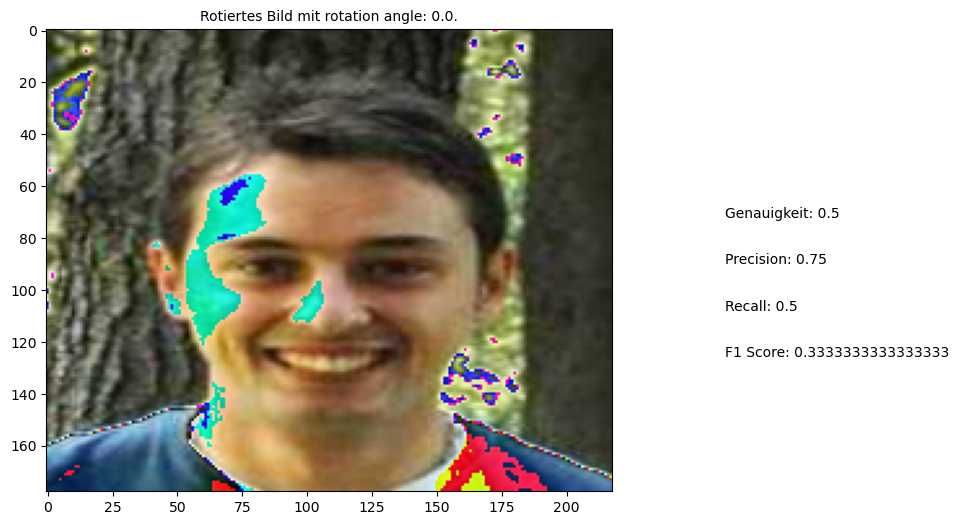

Test mit rotation angle: 90.0
test/test-plots-rotation/1.png


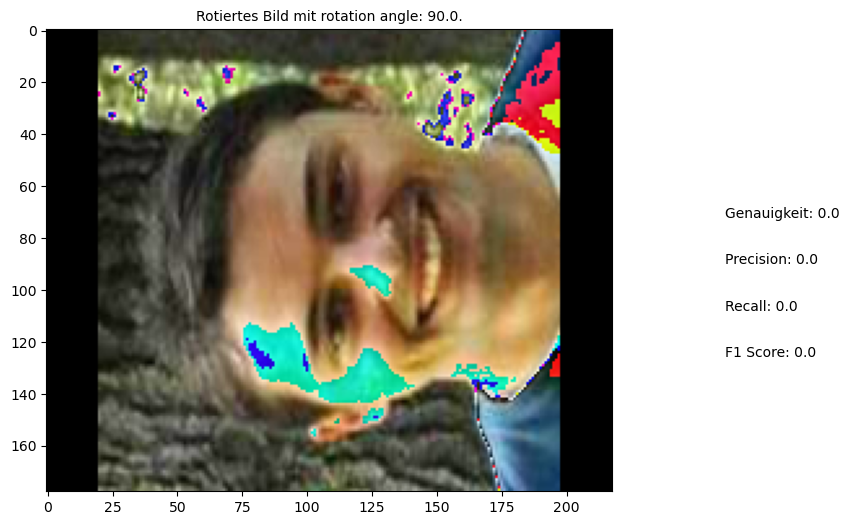

Test mit rotation angle: 180.0
test/test-plots-rotation/2.png


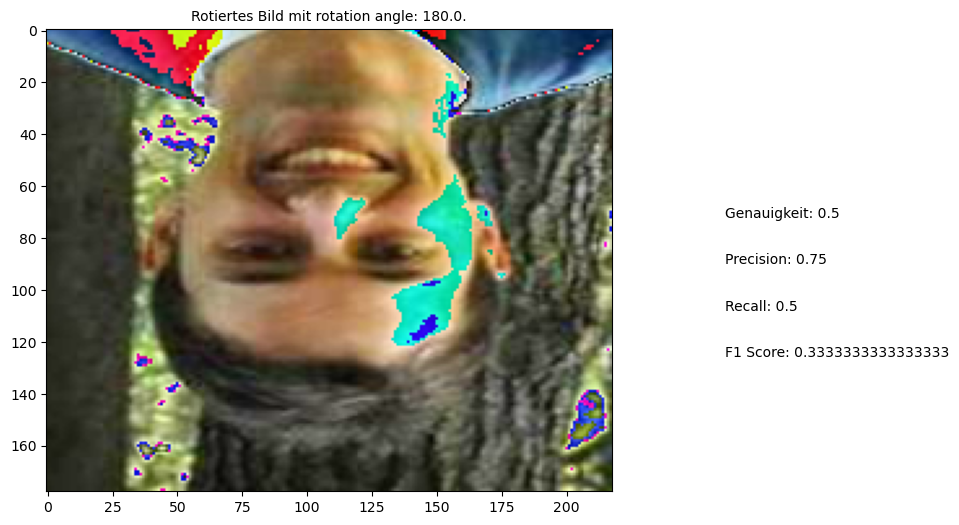

Test mit rotation angle: 270.0
test/test-plots-rotation/3.png


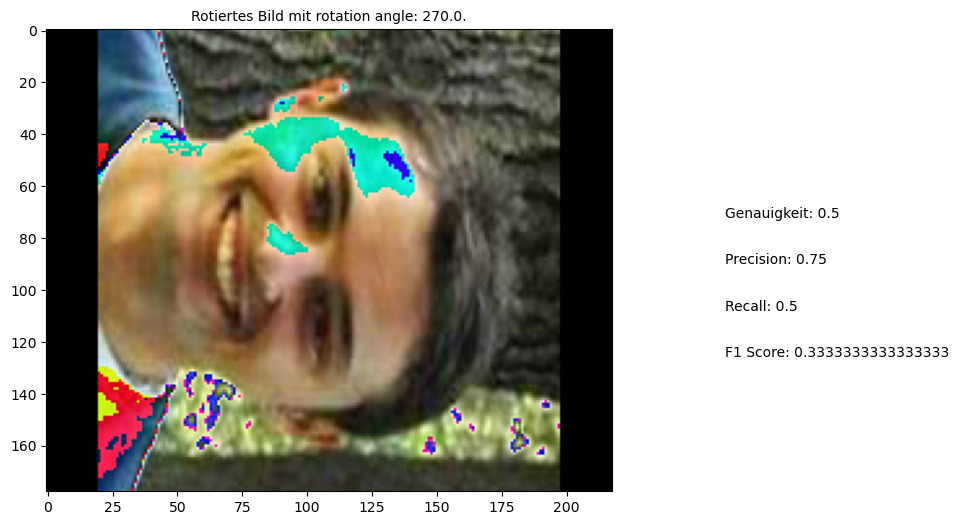

In [77]:
def rotate_image(image, rotation_angle):

    pil_image = transforms.ToPILImage()(image)
    rotated_image = transforms.functional.rotate(pil_image, rotation_angle)
    return transforms.ToTensor()(rotated_image)
    # img = Image.open(image)
    # rotated_img = img.rotate(rotation_angle)



def test_model_robustness_rotation(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Do not calculate gradients to speed up computation
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    return accuracy, precision, recall, f1

def test_rotation_robustness(model, test_dataloader, device, start_angle=0.0, end_angle=270.0, step=90.0):
    rotation_angle = start_angle
    i = 0
    while rotation_angle <= end_angle:
        rotated_images = []
        labels_list = []

        for inputs, labels in test_dataloader:
            # Iteriere über jedes Bild in der Batch
            for input in inputs:
                input_rotated = rotate_image(input, rotation_angle)
                rotated_images.append(input_rotated)
            labels_list.append(labels)

        rotated_images = torch.stack(rotated_images)
        labels_list = torch.cat(labels_list)

        rotated_dataloader = torch.utils.data.DataLoader(list(zip(rotated_images, labels_list)), batch_size=test_dataloader.batch_size)

        print(f'Test mit rotation angle: {rotation_angle}')
        accuracy, precision, recall, f1 = test_model_robustness_rotation(model, rotated_dataloader, device)
        
        # Show a sample rotated image
        plt.figure(figsize=(12, 6))
        plt.title(f'Rotiertes Bild mit rotation angle: {rotation_angle}.', fontsize=10)
        plt.imshow(rotated_images[0].permute(1, 2, 0))
        plt.text(1.2, 0.6, f'Genauigkeit: {accuracy}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.5, f'Precision: {precision}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.4, f'Recall: {recall}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.3, f'F1 Score: {f1}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.savefig(fr"test\test-plot-rotation\{i}.png")
        print(f"test/test-plots-rotation/{i}.png")
        plt.show()


        i += 1
        rotation_angle += step
# Transformation der Daten für das Training und Testen  
transform = transforms.Compose([
    transforms.Resize((178, 218)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 64

    
test_dataset = datasets.ImageFolder(root= r'data\train-test-data\test',transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

test_rotation_robustness(model, test_dataloader, device)

In [52]:
from PIL import Image

def create_and_save_rotated_images(image_path, start_angle=0, end_angle=10, step=1):
    # Bild öffnen
    img = Image.open(image_path)

    for i in range(start_angle, end_angle, step):
        # Bild um i Grad drehen
        rotated_img = img.rotate(i)

        # Bild speichern
        rotated_img.save(fr'C:\CICDPipeline\CICD-Pipeline-Gender-Recognition\test\test-plot-rotation\{i}.png')

# Funktion aufrufen
create_and_save_rotated_images(r'C:\CICDPipeline\CICD-Pipeline-Gender-Recognition\data\train-test-data\train\women\014108.jpg')

# 3. Erklärbarkeit des Modells

In [ ]:
cam_extractor = GradCAMpp(model, "conv2")
men_dir = "data/train-test-data/train/men"
women_dir = "data/train-test-data/train/women"
men_images = [os.path.join(men_dir, img) for img in os.listdir(men_dir)]
women_images = [os.path.join(women_dir, img) for img in os.listdir(women_dir)]
selected_images = random.sample(men_images, 5) + random.sample(women_images, 5)
for i, img_path in enumerate(selected_images):
    img = torchvision.io.read_image(img_path)
    input_tensor = torchvision.transforms.functional.normalize(
        torchvision.transforms.functional.resize(img, (178, 218)) / 255.,
        [0.485, 0.456, 0.406],
        [0.220, 0.224, 0.225]
    )
    out = model(input_tensor.unsqueeze(0))
    activation_map = cam_extractor(1, out)
    activation_map = activation_map[0].squeeze(0).numpy()
    plt.imshow(activation_map, cmap='jet')
    plt.axis('on')
    plt.tight_layout()
    plt.savefig(f'test/activation_map/activation_map_{i}.png')
    plt.show()
